<a href="https://colab.research.google.com/github/Murcha1990/Raiff_PracticalML_May2023/blob/main/Lecture_4_PracticeEDA/Raiff_EDA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи прогноза дохода

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Будем решать задачу прогноза дохода, а именно, *по соц-дем характеристикам людей, будет их доход выше или ниже 50к*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid") 
sns.set(rc={'figure.figsize':(10,5)})

Подключаемся к БД и загружаем данные

*// импорт сертификата одноразовый, он нам каждый раз не нужен - выключим пока*

*// ставить pip и psycopg2 тоже каждый раз не будем*

In [2]:
# !mkdir -p ~/.postgresql && \
# wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
#     --output-document ~/.postgresql/root.crt && \
# chmod 0600 ~/.postgresql/root.crt

In [3]:
# !sudo apt update && sudo apt install --yes python3 python3-pip && \
# !pip3 install psycopg2-binary

In [4]:
try:
    conn = psycopg2.connect("""
        host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
        port=6432
        sslmode=verify-full
        dbname=db_clients
        user=mlhs_student
        password=mlhs_student
        target_session_attrs=read-write
    """)
    query = "SELECT * from public.adult_income"
    data = pd.read_sql_query(query, conn)
    conn.close()
except:
    data = pd.read_csv("adult_income.csv") # читаем припасенные данные, если база отвалилась

Посмотрим на данные.

*Описание аттрибутов таблицы / признаков подопытного населения*:

- **age**: количество полных лет. 
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- **fnlwgt**: continuous. 
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- **education-num**: continuous. 
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- **gender**: Female, Male. 
- **capital-gain**: continuous. 
- **capital-loss**: continuous. 
- **hours-per-week**: continuous. 
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. 




In [5]:
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,NaN,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,NaN,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,NaN,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,NaN,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


In [6]:
data.shape

(9615, 15)

In [7]:
data.dtypes

age                float64
workclass           object
fnlwgt               int64
education           object
educational-num      int64
marital-status      object
occupation          object
relationship        object
race                object
gender              object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9615 entries, 0 to 9614
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8961 non-null   float64
 1   workclass        9615 non-null   object 
 2   fnlwgt           9615 non-null   int64  
 3   education        9615 non-null   object 
 4   educational-num  9615 non-null   int64  
 5   marital-status   9615 non-null   object 
 6   occupation       9615 non-null   object 
 7   relationship     9615 non-null   object 
 8   race             9614 non-null   object 
 9   gender           9614 non-null   object 
 10  capital-gain     9614 non-null   float64
 11  capital-loss     9614 non-null   float64
 12  hours-per-week   8543 non-null   float64
 13  native-country   9614 non-null   object 
 14  income           9614 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 1.1+ MB


## Сохранение данных

In [9]:
data.to_csv("adult_income.csv", index=False)

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [10]:
len(data)

9615

Посмотрим, есть ли в данных пропущенные значения.

In [11]:
data.isna().sum()

age                 654
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  1
gender                1
capital-gain          1
capital-loss          1
hours-per-week     1072
native-country        1
income                1
dtype: int64

Что за единички?

In [12]:
data[data["race"].isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8612,49.0,Private,123681,Assoc-acdm,12,Separated,Sales,Unmarried,None,None,NaN,NaN,NaN,None,None


* пропусков меньше 1% - можно выкинуть строки с пропусками

У нас куча пропусков в одной и той же строке - одна строка нам погоды не делает, следовательно выкидываем эту строку

In [13]:
data = data.drop([data.index[8612]])

In [14]:
data.isna().sum()

age                 654
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week     1071
native-country        0
income                0
dtype: int64

* пропусков меньше 10% - заполняем пропуск каким-то значением
Пропуски в числовых признаках обычно заполняют средним значением или медианой.

In [15]:
len(data[data["age"].isna()]) / len(data)

0.0680257957145829

С полем age всё так и есть, значит заполняем, к примеру, средним 

На всякий случай проверим, насколько у нас близки среднее и медиана

(вряд ли возраст у нас улетит в космос, поэтому медиана тут не особо имеет математический смысл)

In [16]:
median = data['age'].median()
mean = data['age'].mean()
print(median, mean)

data['age'].fillna(mean, inplace=True)

37.0 38.72142857142857


In [17]:
data.isna().sum()

age                   0
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week     1071
native-country        0
income                0
dtype: int64

А если пропусков больше 10%?

Нам не сказали, что делать в этом случае... если просто в лоб заполним медианой, то можем всё испортить

In [18]:
len(data[data["hours-per-week"].isna()]) / len(data)

0.11140004160599126

Посмотрим на эти данные

In [19]:
data[data["hours-per-week"].isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
16,45.000000,Self-emp-not-inc,432824,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298.0,0.0,NaN,United-States,>50K
20,44.000000,Private,26669,Assoc-voc,11,Widowed,Exec-managerial,Unmarried,White,Female,0.0,0.0,NaN,United-States,<=50K
35,32.000000,Private,136921,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
55,54.000000,Private,186272,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,3908.0,0.0,NaN,United-States,<=50K
77,39.000000,Private,118429,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0.0,0.0,NaN,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,38.721429,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,38.721429,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,38.721429,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,38.721429,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


Посмотрим, чем заполнены эти данные в случаях, когда они заполнены

In [20]:
median = data['hours-per-week'].median()
mean = data['hours-per-week'].mean()
print(median, mean)

40.0 40.475125834016154


В среднем работают по 40 часов в неделю, что логично

У каких работничков отсутствуют данные о часах в неделю:

In [21]:
data[data["hours-per-week"].isna()].groupby("workclass")["age"].count()

workclass
?                    59
Federal-gov          23
Local-gov            64
Private             757
Self-emp-inc         29
Self-emp-not-inc     92
State-gov            47
Name: age, dtype: int64

Больше всего тут непонятных приватных (это кто вообще?)

Посмотрим на них:

In [22]:
data[data["workclass"] == "Private"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.000000,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.000000,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
3,44.000000,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,34.000000,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
8,24.000000,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,38.721429,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,38.721429,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,38.721429,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,38.721429,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


Посмотрим долю незаполненных данных по типам работы:

In [23]:
data[data["hours-per-week"].isna()].groupby("workclass")["age"].count() / data.groupby("workclass")["age"].count()

workclass
?                   0.101027
Federal-gov         0.082437
Local-gov           0.105090
Never-worked             NaN
Private             0.115168
Self-emp-inc        0.082153
Self-emp-not-inc    0.117647
State-gov           0.109557
Without-pay              NaN
Name: age, dtype: float64

А что у нас с бездельниками и волонтерами?

In [24]:
data[(data["workclass"] == "Never-worked") | (data["workclass"] == "Without-pay")]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2647,19.0,Without-pay,43627,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0.0,0.0,10.0,United-States,<=50K
2836,74.0,Without-pay,216001,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,20.0,United-States,<=50K
5798,51.0,Without-pay,124963,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K
7870,17.0,Never-worked,131593,11th,7,Never-married,?,Own-child,Black,Female,0.0,0.0,20.0,United-States,<=50K
7976,64.0,Without-pay,209291,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


А что за люди-вопросики?

In [25]:
data[data["workclass"] == "?"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18.000000,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
6,29.000000,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
13,58.000000,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,35.0,United-States,<=50K
22,72.000000,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0.0,0.0,6.0,United-States,<=50K
34,65.000000,?,191846,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9541,18.000000,?,30246,11th,7,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
9543,20.000000,?,49819,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
9568,38.721429,?,150250,Masters,14,Married-civ-spouse,?,Husband,White,Male,0.0,1510.0,NaN,United-States,<=50K
9573,38.721429,?,305145,Bachelors,13,Widowed,?,Not-in-family,White,Male,0.0,0.0,NaN,United-States,<=50K


Посмотрим еще медианы и средние значения, характерные для каждого типа работы:

In [26]:
for key in data["workclass"].unique():
    median = data[data["workclass"] == key]['hours-per-week'].median()
    mean = data[data["workclass"] == key]['hours-per-week'].mean()
    print(key, median, mean)

Private 40.0 40.351444291609354
Local-gov 40.0 40.90091743119266
? 40.0 31.756190476190476
Self-emp-not-inc 40.0 44.88985507246377
Federal-gov 40.0 42.15625
State-gov 40.0 38.175392670157066
Self-emp-inc 48.0 48.23456790123457
Without-pay 32.5 33.75
Never-worked 20.0 20.0


Итого, по сильно выбивающимся из средних показателей безработным и волонтерам у нас пропусков нет

По людям-вопросикам вообще непонятно, что делать - по ним еще и профессия не ясна... м.б. дропнуть всех NaN-ов из этой категории?

В общем, пока не заморачиваемся, а просто заполним пропуски в столбце hours-per-week медианным значением по всей табличке

In [27]:
median = data['hours-per-week'].median()
data['hours-per-week'].fillna(median, inplace=True)

In [28]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

## Ошибочные значения

Смотрим число различных значений в нечисловых столбцах

In [29]:
for i, column in enumerate(data.columns):
    if column not in data.describe().columns:
        print(column)
        print(data[column].value_counts())
# и отдельно для age
print(data["age"].value_counts())

workclass
Private             6573
Self-emp-not-inc     782
Local-gov            609
?                    584
State-gov            429
Self-emp-inc         353
Federal-gov          279
Without-pay            4
Never-worked           1
Name: workclass, dtype: int64
education
HS-grad         3121
Some-college    2125
Bachelors       1598
Masters          545
Assoc-voc        412
11th             358
Assoc-acdm       314
10th             273
7th-8th          186
Prof-school      146
9th              143
12th             121
Doctorate        106
5th-6th           98
1st-4th           48
Preschool         20
Name: education, dtype: int64
marital-status
Married-civ-spouse       4307
Never-married            3238
Divorced                 1303
Widowed                   330
Separated                 297
Married-spouse-absent     130
Married-AF-spouse           9
Name: marital-status, dtype: int64
occupation
Prof-specialty       1222
Exec-managerial      1213
Craft-repair         1183
Adm-cleric

Нашли странный возраст 38.721429

Как-то подозрительно всё-таки вглядят вопросики в столбцах workclass, occupation и native-country

Ну, допустим native-country мы можем заполнить страной по-умолчанию, т.е. сильно преобладающей в выборке

In [30]:
data['native-country'] = data['native-country'].replace('?', 'United-States')

In [31]:
data['native-country'].value_counts()

United-States                 8845
Mexico                         186
Philippines                     51
Puerto-Rico                     41
Germany                         41
Canada                          34
India                           34
El-Salvador                     30
Cuba                            28
England                         21
Poland                          20
South                           20
Haiti                           20
China                           19
Dominican-Republic              18
Portugal                        18
Guatemala                       17
Italy                           15
Jamaica                         15
Ecuador                         13
Columbia                        13
Japan                           12
Peru                            11
Thailand                        10
Nicaragua                        9
Taiwan                           7
Greece                           7
Vietnam                          7
Ireland             

С полем workclass, пожалуй, поступим так же:

In [32]:
data['workclass'] = data['workclass'].replace('?', 'Private')

In [33]:
data['workclass'].value_counts()

Private             7157
Self-emp-not-inc     782
Local-gov            609
State-gov            429
Self-emp-inc         353
Federal-gov          279
Without-pay            4
Never-worked           1
Name: workclass, dtype: int64

А вот с профессией так не получится, там нет преобладающего значения

In [34]:
# data['is_date'] = data['date'].apply(lambda x: 1 if x.isna() else 0)

## Основные числовые характеристики

Распределение целевой переменой

In [35]:
data['income'].value_counts(normalize=True)

<=50K    0.765134
>50K     0.234866
Name: income, dtype: float64

In [36]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,9614.000000,9.614000e+03,9614.000000,9614.000000,9614.000000,9614.000000
mean,38.721429,1.882948e+05,10.080092,1121.998232,87.926669,40.422197
std,13.355951,1.051352e+05,2.562733,7890.578253,404.085647,11.633285
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.154652e+05,9.000000,0.000000,0.000000,40.000000
50%,38.000000,1.778450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.374175e+05,12.000000,0.000000,0.000000,43.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


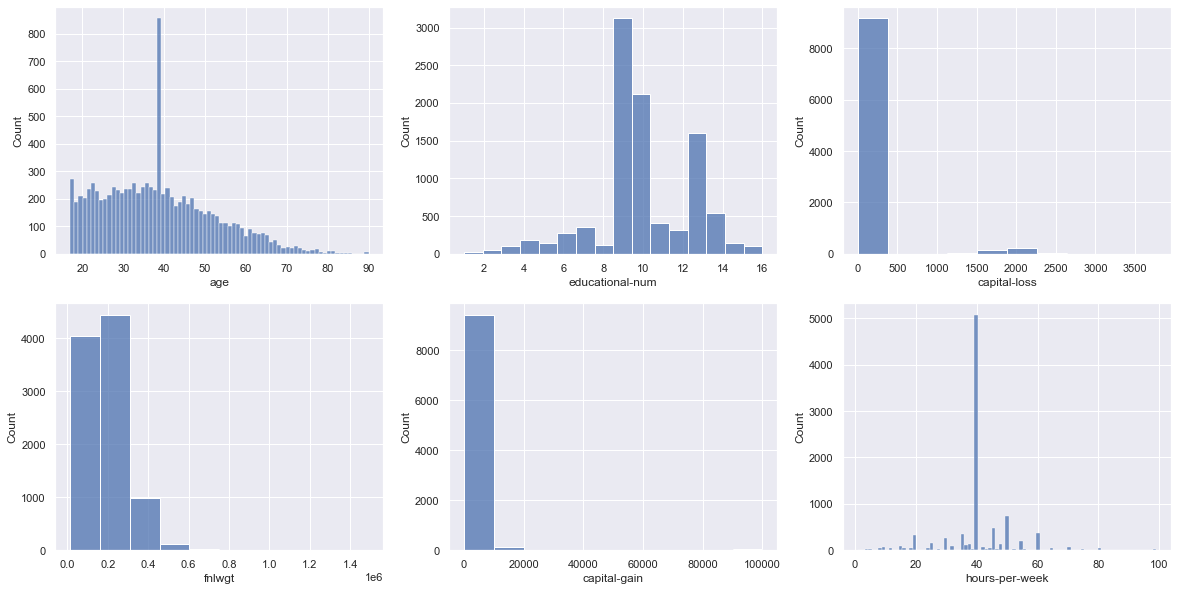

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, column in enumerate(data.describe().columns):
    if column in ["age", "educational-num", "hours-per-week"]:
        bins = len(data[column].unique())
    else:
        bins = 10
    sns.histplot(data[column], ax=axes[i % 2, i // 2], bins=bins)
    
plt.show()

#### Выводы по гистограммам:

- **age**

    есть подозрительный выброс в районе 38 лет, надо бы посмотреть поподробнее, почему в нашей выборке сильно больше таких людей, чем всех остальных

    в остальном - распределение как распределение, похоже на нормальное с обрезанным носиком в начале (оно и понято, дети тут не рассматриваются)

- **educational-num**

    видно 3 всплеска в значениях 9, 10 и 13, надо посмотреть поподробнее, что это значит

- **capital-gain, capital-loss**

    всплеск в нуле, далее незначительные показатели - логично, большая часть населения капиталов не получало и не теряло

    надо бы посмотреть тех, кто не ноль

- **hours-per-week**

    всплеск в значении 40, что логично - подавляющее большинство граждан работает стандартные 40 часов в неделю

    даже и не знаю, нужно ли тут что-то дополнительно изучать

- **fnlwgt**

    непонятная ерунда, не знаю, для чего она

In [38]:
data.describe(include='object') # категориальные колонки

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,9614,9614,9614,9614,9614,9614,9614,9614,9614
unique,8,16,7,15,6,5,2,40,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,7157,3121,4307,1222,3800,8255,6409,8845,7356


У нас целевая колонка текстовая

Добавим пока такую же, но бинарную, чтобы посмотреть корреляцию

In [39]:
data["income_bool"] = data["income"] == ">50K"
data['income_bool'].value_counts(normalize=True)

False    0.765134
True     0.234866
Name: income_bool, dtype: float64

In [40]:
corr = data.corr() # строим матрицу корреляций
corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_bool
age,1.000000,-0.079770,0.002383,0.073273,0.048926,0.081907,0.214954
fnlwgt,-0.079770,1.000000,-0.024398,-0.005989,-0.000409,-0.002930,-0.003089
educational-num,0.002383,-0.024398,1.000000,0.132639,0.083546,0.130397,0.320775
capital-gain,0.073273,-0.005989,0.132639,1.000000,-0.030944,0.094505,0.221998
capital-loss,0.048926,-0.000409,0.083546,-0.030944,1.000000,0.050089,0.139776
hours-per-week,0.081907,-0.002930,0.130397,0.094505,0.050089,1.000000,0.217293
income_bool,0.214954,-0.003089,0.320775,0.221998,0.139776,0.217293,1.000000


Вопрос века: нужно ли нам какие-то данные удалить?

Еще один вопрос века: что значит отрицаельная корреляция поля fnlwgt со всеми подряд другими полями? Что это за поле вообще?

Вот может его и выкинуть из нашей выборки, раз оно ни с чем не коррелирует вообще?

In [41]:
corrcoef_dct = {}
for col in data.columns:
    try:
#         print(col, np.corrcoef(data[col], data['income_bool'])[0][1])
#         corrcoef_arr.append(np.corrcoef(data[col], data['income_bool'])[0][1])
        corrcoef_dct[col] = np.corrcoef(data[col], data['income_bool'])[0][1]
    except:
        pass
sorted_corrcoef_dct = sorted(corrcoef_dct.items(), key=lambda x:x[1], reverse=True)
sorted_corrcoef_dct

[('income_bool', 0.9999999999999999),
 ('educational-num', 0.3207754524730229),
 ('capital-gain', 0.2219983539033911),
 ('hours-per-week', 0.2172928389926224),
 ('age', 0.2149535894898411),
 ('capital-loss', 0.13977556008529074),
 ('fnlwgt', -0.0030885468367829474)]

## Визуализация данных

Посмотрим диаграммы для признаков, имеющих наибольшую корреляцию с целевой переменной

Мы хотим визуально заметить, для каких из этих признаков проявляется более отчетливая зависимость целевой переменной от значений признака

*// На предложенных в материалах занятия графиках типа scatterplot оказалось ничего не видно, поэтому построим гистограммы*

#### educational-num

In [42]:
# plt.scatter(data['educational-num'], data['income'], c=data['income_bool'])

Разберемся с уровнями образования

Из непонятного:
- associate degree (у нас Assoc-acdm, Assoc-voc) - это подготовительная степень (начальное высшее образование в некоторых университетах. Требует два года обучения и дает возможность для обучения на степень бакалавра.)
- professional school (у нас Prof-school) - профессиональная школа (Учебное подразделение третьего цикла (магистратура) в составе университета; факультет, на котором из бакалавра общего профиля готовится специалист. Ведет подготовку юристов, врачей или свободно практикующих специалистов. Курс может завершаться защитой диссертации с присуждением степени магистра (степени доктора медицины на медицинском факультете) или сдачей экзамена с выдачей диплома о специализации.

Если отсортировать по возрастанию, то получится:
(1) Preschool,	(2) 1st-4th,	(3) 5th-6th,	(4) 7th-8th,	(5) 9th,	(6) 10th,	(7) 11th,	(8) 12th,	(9) HS-grad,	(10) Some-college,	(11) Assoc-acdm,	(12) Assoc-voc,	(13) Bachelors,	(14) Prof-school,	(15) Masters,	(16) Doctorate

Итого, циферки 
- 1-8 в поле education-num означают не вполне образованных людей, даже не закончивших школу, 
- 9-12 - людей, закончивших школу и даже местами после нее чему-то обучавшихся, но без высшего образования
- 13-16 - людей с высшим образованием разной степени


Теперь стало понятно, почему пики у нас в точках 9, 10 и 13 - это у нас точки завершния самых массовых уровней образования

Т.е. в нашей выборке люди чаще всего прекращают обучаться, завершив какой-то из 3-х глобальных этапов: 
- (9) закончив школу 
- (10) закончив ПТУ
- (13) получив диплом бакалавра 

<AxesSubplot:xlabel='educational-num', ylabel='Count'>

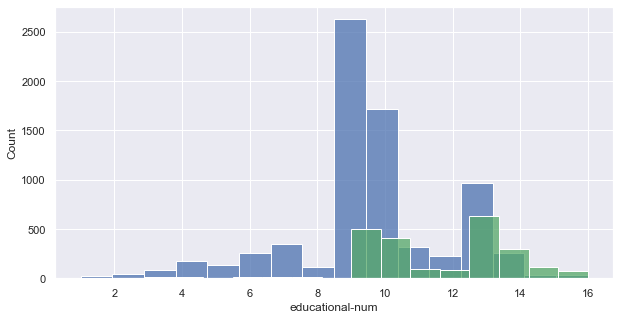

In [43]:
sns.histplot(data[data['income_bool'] == False]['educational-num'], bins=16)
sns.histplot(data[data['income_bool'] == True]['educational-num'], color="g", bins=16)

Объединим наших подопытных в 4 группы: 
1. необразованные совсем (не осилили даже школу)
2. малообразованные (закончили школу или ПТУ)
3. с начальным высшим образованием (законченным или нет)
4. с продвинутым высшим образованием (от магистратуры и дальше)

Посмотрим на доли каждой такой группы в своей страте по доходам

In [44]:
edu_data = data[['educational-num', 'income_bool']]
edu_data['edu_group'] = 2
edu_data.loc[edu_data['educational-num'] < 11, 'edu_group'] = 1
edu_data.loc[edu_data['educational-num'] < 9, 'edu_group'] = 0
edu_data.loc[edu_data['educational-num'] > 13, 'edu_group'] = 3

In [45]:
edu_pivot_poor = pd.pivot_table(edu_data[edu_data['income_bool'] == False], values='educational-num', index=['edu_group'], aggfunc="count").reset_index().rename_axis(None, axis=1)
edu_pivot_poor["label"] = "poor"
edu_pivot_rich = pd.pivot_table(edu_data[edu_data['income_bool'] == True], values='educational-num', index=['edu_group'], aggfunc="count").reset_index().rename_axis(None, axis=1)
edu_pivot_rich["label"] = "rich"

In [46]:
edu_pivot = edu_pivot_poor.append(edu_pivot_rich)
edu_pivot = edu_pivot.rename(columns={"educational-num": "count"})
edu_pivot.loc[edu_pivot['label'] == "poor", 'count'] = edu_pivot[edu_pivot["label"] == "poor"]["count"] / edu_pivot[edu_pivot["label"] == "poor"]["count"].sum()
edu_pivot.loc[edu_pivot['label'] == "rich", 'count'] = edu_pivot[edu_pivot["label"] == "rich"]["count"] / edu_pivot[edu_pivot["label"] == "rich"]["count"].sum()
edu_pivot

,edu_group,count,label
0,0,0.160413,poor
1,1,0.590266,poor
2,2,0.205954,poor
3,3,0.043366,poor
0,0,0.029672,rich
1,1,0.400354,rich
2,2,0.358282,rich
3,3,0.211692,rich


<AxesSubplot:xlabel='edu_group', ylabel='count'>

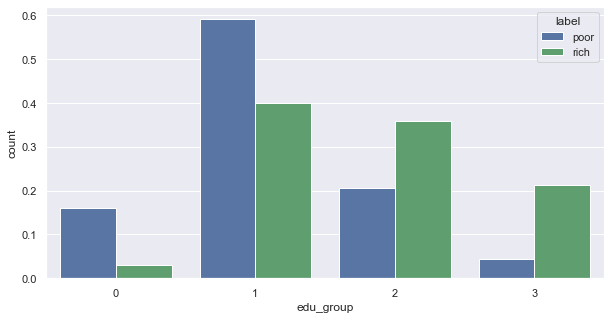

In [47]:
sns.barplot(data=edu_pivot, x='edu_group', y='count', hue='label', palette=['b', 'g'])

И по гистограмме, и по барплоту видно, что, несмотря на схожесть пиковых значений, у нас есть отчетливые различия по распределению:

- среди людей с высоким доходом 
    - очень мало совсем необразованных
    - значимые зеленые столбики начинаются с закончивших школу
    - гистограмма смещена вправо (самые последие 2 ступени образования встречаются только у обеспеченных граждан)
    - практически нет разницы между 2 и 3 группой: условными ПТУ-шниками и условными бакалаврами


- среди людей с низким доходом 
    - скопились почти все наши необразованные (их немного, но сколько есть - все тут)
    - однако, больше всего среди них людей со средним образованием (закончили школу или ПТУ)
    - на гистограмме второй пик значений приходится на закончивших бакалавриат, но не продолживших обучение
    - есть некоторое совсем малое количество поступивших на магистерские программы, но самые высшие 2 ступени образования отсутствуют

#### capital-gain

In [48]:
# plt.scatter(data['capital-gain'], data['income'], c=data['income_bool'])

<AxesSubplot:xlabel='capital-gain', ylabel='Count'>

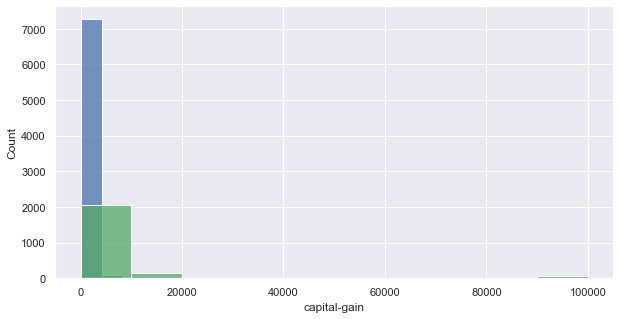

In [49]:
sns.histplot(data[data['income_bool'] == False]['capital-gain'], bins=10)
sns.histplot(data[data['income_bool'] == True]['capital-gain'], color="g", bins=10)

По гистограмме видно, что ноль капитала получают и синенькие, и зелененькие
Посмотрим, какой процент не получивших ничего среди людей с низким и с высоким доходом

In [50]:
print(data[(data['capital-gain'] == 0) & (data["income_bool"] == False)]['capital-gain'].count() / data[(data["income_bool"] == False)]["capital-gain"].count())
print(data[(data['capital-gain'] == 0) & (data["income_bool"] == True)]['capital-gain'].count() / data[(data["income_bool"] == True)]["capital-gain"].count())

0.9575856443719413
0.7891939769707705


На нашей картинке ничего не видно, потому что большинство людей не получает никакого капитала

Поэтому теперь, для прояснения ситуации, попробуем посмотреть на эти данные без нулей

<AxesSubplot:xlabel='capital-gain', ylabel='Count'>

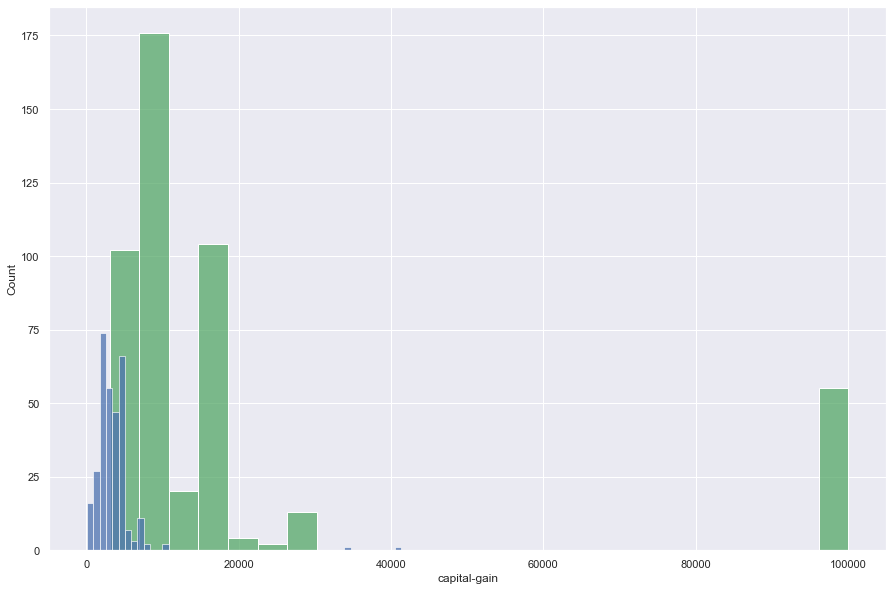

In [51]:
fig, axe = plt.subplots(figsize=(15, 10))
cap_data = data[data['capital-gain'] != 0][['capital-gain', 'income_bool']]
sns.histplot(cap_data[cap_data['income_bool'] == True]['capital-gain'], color="g", bins=25)
sns.histplot(cap_data[cap_data['income_bool'] == False]['capital-gain'], bins=50)

Так уже стало видно, что синяя гистограмма существенно ниже и сильно смещена влево

Т.е. и суммы капиталлов у синеньких значительно скромнее, и получивших их людей значительно меньше

Еще особенность: и у бедных, и у болатых есть давольно далеко от всех прочих своих отстоящие столбики с получившими более крупную (в своем масштабе) сумму капитала. Только среди бедных таких единицы (по ошибке, что ли), а среди богатых - вполне приличный столбец нарисовался

#### hours-per-week

In [52]:
# plt.scatter(data['hours-per-week'], data['income'], c=data['income_bool'])

<AxesSubplot:xlabel='hours-per-week', ylabel='Count'>

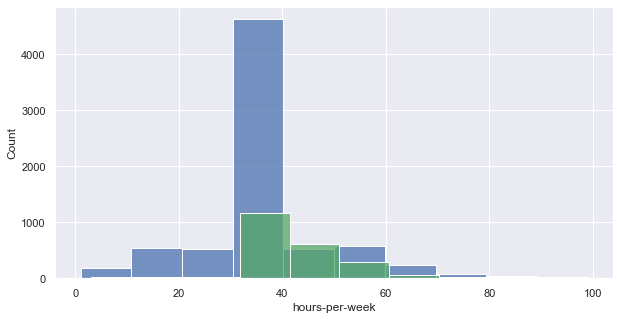

In [53]:
sns.histplot(data[data['income_bool'] == False]['hours-per-week'], bins=10)
sns.histplot(data[data['income_bool'] == True]['hours-per-week'], color="g", bins=10)

Тут всё довольно наглядно на первой картинке, можно глубже и не копать

Среди людей с высоким доходом практически нет тех, кто работает менее стандартных 40 часов в неделю

А вот расслабленные мало вкалывающие граждане почему-то все оказались синенькими )))

Правда, сильно много вкалывающие граждане тоже оказались там же, среди бедных - возможно, это связано со спецификой низкоквалифицированного труда

#### age

In [54]:
# plt.scatter(data['age'], data['income'], c=data['income_bool'])

<AxesSubplot:xlabel='age', ylabel='Count'>

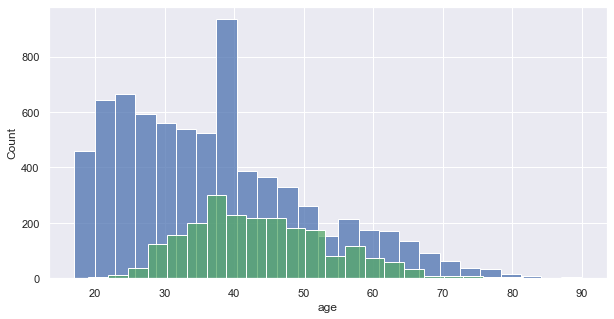

In [55]:
sns.histplot(data[data['income_bool'] == False]['age'], bins=25)
sns.histplot(data[data['income_bool'] == True]['age'], color="g", bins=25)

Посмотрим еще как различаются богатые и бедные по возрастам не в абсолютных количествах, а с нормализацией

In [56]:
data_norm_age = data.copy()
data_norm_age['age_10'] = data_norm_age['age'] // 10 * 10
data_norm_pivot = pd.pivot_table(data_norm_age, values=['age'], index=['age_10', 'income_bool'], aggfunc="count").reset_index().rename_axis(None, axis=1)
data_norm_pivot = data_norm_pivot.rename(columns={"age": "count"})
data_norm_pivot.loc[data_norm_pivot['income_bool'] == False, "count"] = data_norm_pivot[data_norm_pivot['income_bool'] == False]['count'] \
                                                                        / max(data_norm_pivot[data_norm_pivot['income_bool'] == False]['count'])
data_norm_pivot.loc[data_norm_pivot['income_bool'] == True, "count"] = data_norm_pivot[data_norm_pivot['income_bool'] == True]['count'] \
                                                                        / max(data_norm_pivot[data_norm_pivot['income_bool'] == True]['count'])

<AxesSubplot:xlabel='age_10', ylabel='count'>

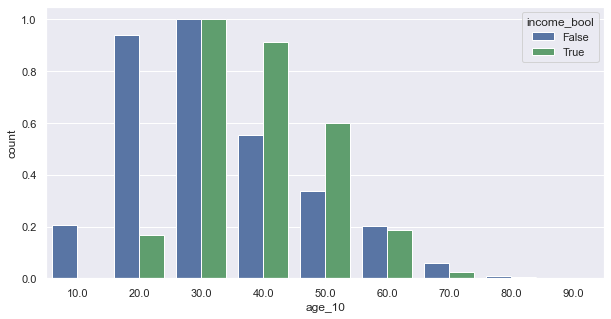

In [57]:
sns.barplot(data=data_norm_pivot, x='age_10', y='count', hue='income_bool', palette=['b', 'g'])

Тут обе картинки показательные: молодежи среди низкодоходных граждан сильно больше

Будущие богатые, вероятно, в левой части графиков усиленно учатся - поэтому пока они студенты-аспиранты и не имеют особых доходов, они отображаются в синих столбиках, а на работу (уже высокооплачиваемую) выходят годам ближе к 30

Существенная часть из тех, кто имеет хороший доход, вероятно, зарабатывали его себе сами в течение ~20 первых лет трудовой деятельности. На гистограмме зелененькие растут постепенно лесенкой после 25 и до 40, на нормализованном к максимуму в своей когорте графике доля обеспеченных 40-50 летних сильно опережает долю необеспеченных тех же возрастов.

Судя по нашим картинкам, возраст должен быть довольно значимым показателем для модельки, т.к. логика для корреляции тут вроде есть.

Мы хотели посмотрить, что там за аномалия с 38-летними

In [58]:
age_data = data.groupby('age')['income'].count()
age_data[37:40]

age
37.000000    242
38.000000    232
38.721429    654
39.000000    201
40.000000    218
Name: income, dtype: int64

Какая-то ошибка вкралась в наши данные, похоже

Посмотрим, что за люди такие, которые по неведомой причине идентифицировали свой возраст как 38.721429

In [59]:
age_err = data[abs(data["age"] - 38.7) < 0.1]
age_err

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,income_bool
1439,38.721429,Private,257405,5th-6th,3,Never-married,Farming-fishing,Unmarried,Black,Male,0.0,0.0,40.0,Mexico,<=50K,False
8613,38.721429,Private,504725,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,3464.0,0.0,40.0,Mexico,<=50K,False
8614,38.721429,State-gov,444554,Some-college,10,Never-married,Other-service,Own-child,White,Male,0.0,0.0,25.0,United-States,<=50K,False
8615,38.721429,Private,107914,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0.0,0.0,47.0,United-States,>50K,True
8616,38.721429,Local-gov,403681,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,>50K,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,38.721429,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,>50K,True
9611,38.721429,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,False
9612,38.721429,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,40.0,United-States,<=50K,False
9613,38.721429,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,40.0,United-States,>50K,True


Какой у нас процент в базе таких косячных возрастов?

In [60]:
len(data[abs(data["age"] - 38.7) < 0.1]) / len(data)

0.0680257957145829

Как они себя ведут?

In [61]:
age_err.describe(include='all') 

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,income_bool
count,6.540000e+02,654,654.000000,654,654.000000,654,654,654,654,654,654.000000,654.000000,654.000000,654,654,654
unique,NaN,6,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,22,2,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K,False
freq,NaN,496,NaN,218,NaN,300,92,263,561,437,NaN,NaN,NaN,602,499,499
mean,3.872143e+01,NaN,182344.655963,NaN,10.111621,NaN,NaN,NaN,NaN,NaN,1935.169725,77.492355,40.652905,NaN,NaN,NaN
std,3.484324e-13,NaN,96941.636313,NaN,2.617778,NaN,NaN,NaN,NaN,NaN,11313.487325,376.072672,11.998099,NaN,NaN,NaN
min,3.872143e+01,NaN,13769.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN
25%,3.872143e+01,NaN,112213.000000,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN,NaN
50%,3.872143e+01,NaN,172336.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN,NaN
75%,3.872143e+01,NaN,230632.500000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN,NaN


Предположим, что кто-то неловко дернул мышкой и все эти данные с непонятным дробным возрастом вклинились в нашу выборку случайно

Откуда они могли взяться?

М.б. это дубликаты других строк?

In [62]:
data_ex_age = data.drop(['age'], axis=1)
duplicateRows = data_ex_age[data_ex_age.duplicated()]
duplicateRows

,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,income_bool
774,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,0.0,35.0,United-States,<=50K,False
7753,Private,324655,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,False
9218,Private,334593,Some-college,10,Never-married,?,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,False


Нет, не дубликаты

In [63]:
corr = age_err.corr() # строим матрицу корреляций по кусочку базы с косячным возрастом
corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_bool
age,nan,nan,nan,nan,nan,nan,nan
fnlwgt,nan,1.000000,-0.026898,0.052389,-0.029231,0.007533,0.040941
educational-num,nan,-0.026898,1.000000,0.198699,0.024968,0.142827,0.361112
capital-gain,nan,0.052389,0.198699,1.000000,-0.035300,0.119994,0.277304
capital-loss,nan,-0.029231,0.024968,-0.035300,1.000000,-0.012416,0.070928
hours-per-week,nan,0.007533,0.142827,0.119994,-0.012416,1.000000,0.192188
income_bool,nan,0.040941,0.361112,0.277304,0.070928,0.192188,1.000000


А давайте всех их грохнем! 
У нас их таких всего 6 % от общего объема данных, не должно повлиять на модельку в худшую сторону

In [64]:
data = data[abs(data["age"] - 38.7) > 0.1]
data.shape

(8960, 16)

Не... посмотрели там ниже на коэффициенты линейной модели - пожалуй, не будем добавлять, ничего это не улучшает в нашей модели

// Добавим еще в наши данные пару каких-нить расчетных колонок, развернем пару категориальных в столбцы и посмотрим, что лучше коррелирует

In [65]:
# for i, value in enumerate(data['educational-num'].unique()):
#     tmp = edu_data[edu_data['educational-num'] == value].iloc[0, 2]
# data['age_10'] = data['age'] // 10 * 10
# for i, value in enumerate(data['race'].unique()):
#     print(i, value)

In [66]:
corr = data.corr() # строим матрицу корреляций по кусочку базы без косячного возраста
corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_bool
age,1.000000,-0.082189,0.002472,0.079032,0.050434,0.085038,0.222712
fnlwgt,-0.082189,1.000000,-0.024185,-0.011411,0.001262,-0.003567,-0.006023
educational-num,0.002472,-0.024185,1.000000,0.126197,0.087646,0.129423,0.317757
capital-gain,0.079032,-0.011411,0.126197,1.000000,-0.030631,0.092165,0.217747
capital-loss,0.050434,0.001262,0.087646,-0.030631,1.000000,0.054512,0.144485
hours-per-week,0.085038,-0.003567,0.129423,0.092165,0.054512,1.000000,0.219194
income_bool,0.222712,-0.006023,0.317757,0.217747,0.144485,0.219194,1.000000


После варварского отстрела косячных данных возраст, похоже, выбился на 2-е место по значимости для модельки

Посчитаем среднее значение признака с наибольшей корреляцией для клиентов с высоким и с низким доходом, используйте groupby.

In [67]:
data.groupby('income')['educational-num'].mean()

income
<=50K     9.627534
>50K     11.545887
Name: educational-num, dtype: float64

Попробуем заменить некоторые колоночки на наши расчетные и посмотреть, что изменится в предсказаниях

Немного почистим еще наши данные.

Выяснили, что наша модель не вполне работает с текстовым целевым значением. Потому сделаем наоборот: текстовое грохнем, а бинарное оставим

//Выкинем нами добавленный чисто технический income_bool, который был нужен для просмотра корреляции

А еще выкинем непонятный fnlwgt, потому что так и не поняли, что это

In [68]:
data = data.drop(['fnlwgt', 'income'], axis=1)
# data = data.drop(['fnlwgt', 'income_bool'], axis=1)

In [69]:
data.describe(include='object') 

,workclass,education,marital-status,occupation,relationship,race,gender,native-country
count,8960,8960,8960,8960,8960,8960,8960,8960
unique,8,16,7,15,6,5,2,40
top,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
freq,6661,2903,4007,1139,3537,7694,5972,8243


## <font color='green'>2.1. Обучение модели</font>



In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации
from sklearn.neighbors import KNeighborsClassifier # метод ближайших соседей
from catboost import CatBoostClassifier, Pool # градиентный бустинг
from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [71]:
# X = data.drop('income', axis=1) # матрица объект-признак
# y = data['income'] # целевая переменная

X = data.drop('income_bool', axis=1) # матрица объект-признак
y = data['income_bool'] # целевая переменная

Применим логистическую регрессию для прогноза дохода

Сначала выкинем нечисловые столбцы.

In [72]:
X_full = X.copy()
X = X.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'], axis=1)

In [73]:
X.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week
0,25.0,7,0.0,0.0,40.0
1,38.0,9,0.0,0.0,50.0
2,28.0,12,0.0,0.0,40.0
3,44.0,10,7688.0,0.0,40.0
4,18.0,10,0.0,0.0,30.0


Разобъём данные на train и test (test — 25% от всех данных).

In [74]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=44)

Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [75]:
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(6720, 5) (2240, 5) (6720,) (2240,)


In [76]:
ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week
0,-1.357276,-0.033662,-0.140483,-0.218176,-0.038528
1,1.407204,1.518367,-0.140483,-0.218176,0.821341
2,-0.484282,-0.421669,-0.140483,-0.218176,-0.038528
3,0.679710,1.518367,0.950524,-0.218176,0.821341
4,-1.211777,-1.585691,-0.140483,-0.218176,-0.898397


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [77]:
model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [78]:
pred_test = model.predict(Xtest) # предсказание классов

Посмотрим на предсказания модели и оценим ее качество.

In [79]:
metrics.accuracy_score(ytest, pred_test) 

0.8125

Проверим, сбалансирована ли выборка.

In [80]:
y.value_counts()

False    6857
True     2103
Name: income_bool, dtype: int64

Баланса классов нет: большинство имеет низкий доход ($y="<=50K"  или False в случае бинарного y). 

Посмотрим, что предсказывает модель.

In [81]:
# pred_test[:10]
pd.DataFrame(pred_test).value_counts()

False    1982
True      258
dtype: int64

А вот что было правильно

In [82]:
pd.DataFrame(ytest).value_counts()

income_bool
False          1712
True            528
dtype: int64

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Давайте посмотрим, какие метрики полезно считать в задаче классификации, кроме accuracy.

<font color='blue'>Для оценки качества моделей бинарной классификации полезно смотреть на **матрицу ошибок** (confusion matrix):</font>

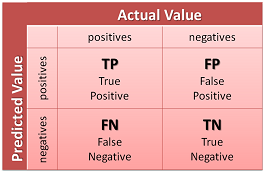

In [83]:
cm_arr = metrics.confusion_matrix(ytest, pred_test)
cm_arr

array([[1637,   75],
       [ 345,  183]], dtype=int64)

Учитывая значения нашего pred_test, в контексте матрицы ошибок получается, что бедные - это у нас позитивное событие, а богатые - негативное событие

Ну ок, воспримем это как данность ))

Пробуем посмотреть, как работают метрики через sklearn.metrics и по заявленным в определении метрики формулам

In [84]:
TP = cm_arr[0][0] # 1631
FP = cm_arr[0][1] # 85
FN = cm_arr[1][0] # 313
TN = cm_arr[1][1] # 211

In [85]:
ytest.value_counts()

False    1712
True      528
Name: income_bool, dtype: int64

Наша модель много лишних людей неправильно определила в бедных (False Negative)

Посмотрим на метрику **Precision (точность)**

Precision - это доля правильно угаданных позитивных событий среди всех, которые МЫ назвали позитивными: TP / (TP + FP)

In [86]:
metrics.precision_score(ytest, pred_test)

0.7093023255813954

In [87]:
print("TP / (TP + FP): ", TP, "/", TP + FP, "=", TP / (TP + FP))

TP / (TP + FP):  1637 / 1712 = 0.9561915887850467


Что-то оценка sklearn с формулой не сходится

Посмотрим еще на метрику **Recall (полнота)**

Recall - это доля правильно угаданных позитивных событий среди всех, которые НА САМОМ ДЕЛЕ были позитивными: TP / (TP + FN)

In [88]:
metrics.recall_score(ytest, pred_test)

0.3465909090909091

In [89]:
print("TP / (TP + FN): ", TP, "/", TP + FN, "=", TP / (TP + FN))

TP / (TP + FN):  1637 / 1982 = 0.8259334006054491


И тут оценка sklearn с формулой не сходится

Ну и ладно, ну и пожалуйста... 

Ну и еще посмотрим на auc_roc, как на общую метрику качества модели

In [90]:
metrics.roc_auc_score(ytest, pred_test)
lr1_roc_auc_score = metrics.roc_auc_score(ytest, pred_test)
print(lr1_roc_auc_score)

0.651391248937978


Ну, не так, чтобы очень плохо... но попробуем улучшить

В любом случае, по смыслу получается так:

Большая часть из тех, кого мы определили в бедные - действительно бедные

Но, при этом, если смотреть на всех действительно бедных, довольно большая их часть у нас попала в FN, т.е. мы разметили их как богатых

Почему так произошло?

Посмотрим на вероятности, выдаваемые моделью.

In [91]:
probs = model.predict_proba(Xtest)
probs[:10]

array([[0.74996219, 0.25003781],
       [0.86492638, 0.13507362],
       [0.83831868, 0.16168132],
       [0.86587314, 0.13412686],
       [0.68969301, 0.31030699],
       [0.90766458, 0.09233542],
       [0.71907214, 0.28092786],
       [0.95566248, 0.04433752],
       [0.49424948, 0.50575052],
       [0.93979981, 0.06020019]])

С вероятностями тут всё значительно лучше, чем было в учебном примере - они не всегда 90%+ в одну категорию и даже периодически меняются местами

Попробуем подобрать пороговый коэффициент, ниже которого всех людей определяем в бедные

In [92]:
def best_coef(probs_income):
    max_auc_roc = 0
    for i in range(0, 100):
        classes = probs_income > i/100
    #     print(i/100)
    #     print(metrics.confusion_matrix(ytest, classes))
    #     print("auc_roc:", metrics.roc_auc_score(ytest, classes))
        if max_auc_roc < metrics.roc_auc_score(ytest, classes):
            max_auc_roc = metrics.roc_auc_score(ytest, classes)
            res = i/100
    print("best_coef =", res)
    return res
probs_income = probs[:,1]
classes = probs_income > best_coef(probs_income)
lr2_roc_auc_score = metrics.roc_auc_score(ytest, classes)
print(lr2_roc_auc_score)

best_coef = 0.23
0.7323704333050127


Подобрали оптимальный коэффициент, посмотрим, что получилось с ним

In [93]:
cm_arr = metrics.confusion_matrix(ytest, classes)
cm_arr

array([[1282,  430],
       [ 150,  378]], dtype=int64)

In [94]:
pd.DataFrame(classes).value_counts()

False    1432
True      808
dtype: int64

In [95]:
ytest.value_counts()

False    1712
True      528
Name: income_bool, dtype: int64

In [96]:
metrics.recall_score(ytest, classes)

0.7159090909090909

Теперь модель стала находить оттоковых клиентов, но и больше ошибается на тех клиентах, которые не уйдут.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [97]:
model.coef_, model.intercept_

(array([[0.57800391, 0.83138172, 2.2831114 , 0.23806556, 0.46657423]]),
 array([-1.39045607]))

In [98]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})
coef_table.sort_values(by='weights')

,features,weights
3,capital-loss,0.238066
4,hours-per-week,0.466574
0,age,0.578004
1,educational-num,0.831382
2,capital-gain,2.283111


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

## Метод ближайших соседей (бонус)

Существует еще один простой метод для решения задач классификации - метод ближайших соседей.

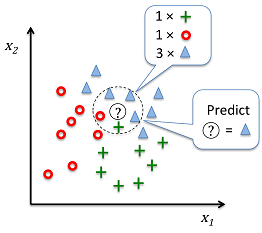

Попробуем применить метод ближайших соседей для решения поставленной задачи.

In [99]:
knn = KNeighborsClassifier()

In [100]:
knn.fit(Xtrain, ytrain)
pred_test2 = knn.predict_proba(Xtest)[:,1]
classes2 = pred_test2 > best_coef(pred_test2)
metrics.confusion_matrix(ytest, classes2)
knc_roc_auc_score = metrics.roc_auc_score(ytest, classes2)

best_coef = 0.2


## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [101]:
Xtest_to_save = Xtest.copy()
Xtest_to_save['predictions'] = probs_income
Xtest_to_save[['predictions']].to_csv("PredictionsIncome.csv", index=False)

Теперь сохраним саму модель:

In [102]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

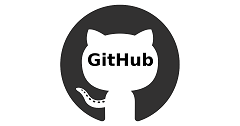

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [103]:
print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, classes))

LR quality:
precision:  0.46782178217821785
recall:  0.7159090909090909
auc-roc:  0.7323704333050127


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [104]:
# !pip install catboost

In [105]:
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(6720, 5) (2240, 5) (6720,) (2240,)


In [106]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [107]:
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

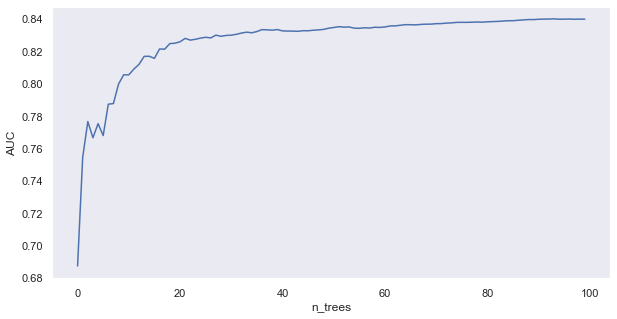

In [108]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [109]:
gbm_income = gbm_preds[:, 1]
gbm_classes = (gbm_income > best_coef(gbm_income))
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_classes))
gbm_roc_auc_score = metrics.roc_auc_score(ytest, gbm_classes)

best_coef = 0.29
precision:  0.5651438240270727
recall:  0.6325757575757576
auc-roc:  0.7412294675729255


In [110]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
3,capital-loss,8.073552
4,hours-per-week,11.421170
2,capital-gain,22.176013
1,educational-num,22.812598
0,age,35.516667


## Вопрос для Quiz

Попробуйте обучить градиентный бустинг с другой длиной шага. Получится ли улучшить AUC-ROC на тесте?

In [111]:
# ваш код здесь

## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [112]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=44)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((6720, 13), (2240, 13), (6720,), (2240,))

In [113]:
srt1 = ""
for index, name in enumerate(Xtrain.columns):
    if name not in X.columns:
        srt1 += "'" + name + "', "
print(srt1)

'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 


In [114]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [115]:
X_transformed.shape, X_test_transformed.shape

((6720, 103), (2240, 103))

А что там внутри?

In [116]:
df_X_transformed = pd.DataFrame(X_transformed.toarray())
df_X_transformed

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.357276,-0.033662,-0.140483,-0.218176,-0.038528
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.407204,1.518367,-0.140483,-0.218176,0.821341
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.484282,-0.421669,-0.140483,-0.218176,-0.038528
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.679710,1.518367,0.950524,-0.218176,0.821341
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.211777,-1.585691,-0.140483,-0.218176,-0.898397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.571196,-0.421669,-0.140483,5.454762,-0.468462
6716,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.116206,-0.421669,-0.140483,3.828951,-0.038528
6717,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.606960,-0.421669,-0.140483,4.445467,0.649368
6718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.116206,1.518367,-0.140483,-0.218176,0.133446


Ну и прогоним все эти единички и нолики через модель логистической регрессии с подбором коэффициента

In [117]:
model = LogisticRegression(solver='liblinear')
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [118]:
pred_income = pred[:, 1]
classes = (pred_income > best_coef(pred_income))
# classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, classes))
lr_categ_roc_auc_score = metrics.roc_auc_score(ytest, classes)

best_coef = 0.21
precision:  0.5612745098039216
recall:  0.8674242424242424
auc-roc:  0.829156046445766


И её же через модель градиентного бустинга

In [119]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_income = gbm_preds[:, 1]
gbm_classes = (gbm_income > best_coef(gbm_income))
# gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_classes))
gbm_categ_roc_auc_score = metrics.roc_auc_score(ytest, gbm_classes)

best_coef = 0.28
precision:  0.6087551299589603
recall:  0.8428030303030303
auc-roc:  0.8378734777683375


In [120]:
print("Логистическая регрессия без категориальных параметров: auc_roc = ", lr1_roc_auc_score)
print("Логистическая регрессия без категориальных параметров с подбором коэффициента: auc_roc = ", lr2_roc_auc_score)
print("Метод ближайших соседей: auc_roc = ", knc_roc_auc_score)
print("Градиентный бустинг без категориальных параметров с подбором коэффициента: auc_roc = ", gbm_roc_auc_score)
print("Логистическая регрессия с учетом категориальных параметров и с подбором коэффициента: auc_roc = ", lr_categ_roc_auc_score)
print("Градиентный бустинг с учетом категориальных параметров и с подбором коэффициента: auc_roc = ", gbm_categ_roc_auc_score)

Логистическая регрессия без категориальных параметров: auc_roc =  0.651391248937978
Логистическая регрессия без категориальных параметров с подбором коэффициента: auc_roc =  0.7323704333050127
Метод ближайших соседей: auc_roc =  0.7036073350325687
Градиентный бустинг без категориальных параметров с подбором коэффициента: auc_roc =  0.7412294675729255
Логистическая регрессия с учетом категориальных параметров и с подбором коэффициента: auc_roc =  0.829156046445766
Градиентный бустинг с учетом категориальных параметров и с подбором коэффициента: auc_roc =  0.8378734777683375


#### Итоговый вывод

Наилучшие результаты на нашей выборке показала модель градиентнного бустинга с учетом категориальных параметров и с подбором порогового коэффициента